# xtensor-io

Effortless loading of images, audio files and NumPy npz files!

In [1]:
#include <string>
#include <fstream>
#include "xtl/xbase64.hpp"
#include "xwidgets/xslider.hpp"
#include "xtensor/xview.hpp"
#include "xtensor/xio.hpp"

In [2]:
#include "xtensor-io/ximage.hpp"
#include "xtensor-io/xaudio.hpp"
#include "xtensor-io/xnpz.hpp"

In [3]:
template <class E>
auto display(const xt::xexpression<E>& e, xeus::xguid id = xeus::xguid(), bool update = false)
{
    xt::dump_image("/tmp/xio_image.png", e);
    std::ifstream fin("/tmp/xio_image.png", std::ios::binary);
    std::stringstream buffer;
    buffer << fin.rdbuf();

    xeus::xjson mime;
    mime["image/png"] = xtl::base64encode(buffer.str());
    xeus::xjson transient;

    if (update)
    {
        transient["display_id"] = id;
        xeus::get_interpreter().update_display_data(
            std::move(mime),
            xeus::xjson::object(),
            std::move(transient));
        return id;
    }
    else
    {
        id = xeus::new_xguid();
        transient["display_id"] = id;
        xeus::get_interpreter().display_data(
            std::move(mime),
            xeus::xjson::object(),
            std::move(transient));
        return id;
    }
}

### Loading an image

In the following an image is loaded from the file system, and then displayed using the above helper function.
The slider can be used to make the lightsaber more-or-less xtensor-green!

In [4]:
auto lightsaber = xt::load_image("images/saber.png");

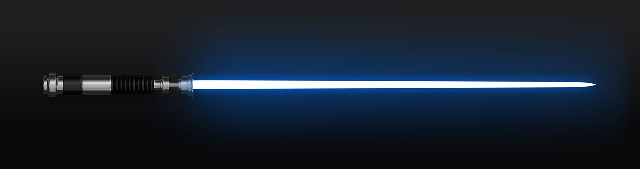

In [5]:
auto display_id = display(lightsaber);

In [6]:
template <class E>
void modify_image(xt::xexpression<E>& e, double value)
{
    xt::xarray<double> lightsaber_modified = e.derived_cast();
    double inc = value / 5.;
    xt::xarray<double> filter = {1. - inc, 1. + inc, 1. - inc};
    lightsaber_modified *= filter;
    xt::xarray<uint8_t> lightsaber_display = xt::cast<uint8_t>(xt::clip(lightsaber_modified, 0, 255));
    display(lightsaber_display, display_id, true);
}

In [7]:
xw::slider<double> slider;
slider.max = 5;
slider.value = 2;
slider.continuous_update = false;
slider.display();
XOBSERVE(slider, value, [](const auto& s) {
    modify_image(lightsaber, s.value());
});

A Jupyter widget

### Loading Audio

In the next example a WAV file is loaded from the file system. The `load_audio` function returns a tuple, where the first value is the samplerate and the second value is an xarray holding the sound data.

In [8]:
auto swing = xt::load_audio("sounds/lightsaber_swing.wav");

In [9]:
int sample_rate = std::get<0>(swing);
auto audio_data = std::get<1>(swing);

In [10]:
template <class E>
auto player(const xt::xexpression<E>& e, int sample_rate, xeus::xguid id = xeus::xguid(), bool update = false)
{
    using namespace std::string_literals;
    xt::dump_audio("/tmp/xio_audio.wav", e, sample_rate);
    std::ifstream fin("/tmp/xio_audio.wav", std::ios::binary);
    std::stringstream buffer;
    buffer << fin.rdbuf();

    xeus::xjson mime;
    mime["text/html"] = std::string("<audio autoplay controls loop src=\"data:audio/wav;base64,") + 
                        xtl::base64encode(buffer.str()) + "\"/>";
    xeus::xjson transient;

    if (update)
    {
        transient["display_id"] = id;
        xeus::get_interpreter().update_display_data(
            std::move(mime),
            xeus::xjson::object(),
            std::move(transient));
        return id;
    }
    else
    {
        id = xeus::new_xguid();
        transient["display_id"] = id;
        xeus::get_interpreter().display_data(
            std::move(mime),
            xeus::xjson::object(),
            std::move(transient));
        return id;
    }
}

In [ ]:
auto audio_id = player(std::get<1>(swing), sample_rate);

In [12]:
xw::slider<int> samplerate_slider;
samplerate_slider.max = 50000;
samplerate_slider.value = sample_rate;
samplerate_slider.continuous_update = false;
samplerate_slider.display();

XOBSERVE(samplerate_slider, value, [](const auto& s) {
    player(std::get<1>(swing), s.value(), audio_id, true);
});

A Jupyter widget